# Predicting COVID-19 from chest X-ray images.

## 1. Import relevant libraries

In [108]:
# Libraries to open data
import os
import pickle

# Torch and PIL libraries for image preprocessing
from PIL import Image
import torch
import torchvision

# numpy and matplotlib.pyplot to visualize data
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Define constants

In [109]:
# Verbose levels
VERBOSE = {
    'progress': True,
    'augmenting': False,
}

# Pathnames and filenames
DIR = {'data': os.path.join('..', 'data'), 'images': os.path.join('..', 'images')}
FILENAMES = {
    'X_train': os.path.join(DIR['data'], 'train_images_512.pk'),
    'y_train': os.path.join(DIR['data'], 'train_labels_512.pk'),
    'X_test': os.path.join(DIR['data'], 'test_images_512.pk'),
}

# Parameters to load raw data
SHIFT, SCALE = 1, 127.5  # data = (data + 1) * 127.5
SIZE = {'raw': 512, 'final': 256} # size of raw data and data after downsampling

# Relative amount of data used for training vs validation
TRAIN_VALID_RATIO = 2 / 1  # i.e. ratio of training data : validation data = 2:1

# Parameters for data augmentation
N_TRAIN = 100
POS_NEG_RATIO = 1 / 1 # negative : positive samples in augmented training set = 1:1

# Parameters for data augmentation
TRANSFORMATIONS = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.RandomAffine(degrees=15, translate=(0.02, 0.02), scale=(1, 1.15)),
    torchvision.transforms.ColorJitter(contrast=0.4, brightness=0.4),
    torchvision.transforms.RandomErasing(p=0.3, scale=(0.01, 0.03), ratio=(1 / 3, 3)),
    torchvision.transforms.ToTensor(),
])

## 3. Define functions

In [110]:
# Function to print progress
def verbose_print(message, print_flag, end='\n'):
    if print_flag:
        print(message, end=end)

In [111]:
# Functions to load data
def load_pk(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f, encoding='bytes')

def load_X(filename):
    X = load_pk(filename)
    assert X.size(2) == X.size(3) == SIZE['raw']
    return SCALE * (X[:, :1, :, :] + SHIFT)

def load_y(filename):
    y = load_pk(filename)
    return y.type(torch.long)  # convert to integer

In [112]:
# Functions to preprocess data
def downsample(X):
    f = SIZE['raw'] // SIZE['final']
    for i in range(SIZE['final']):
        for j in range(SIZE['final']):
            X[:, :, i, j] = X[:, :, i * f:(i + 1) * f, j * f:(j + 1)*f].mean(-1).mean(-1)
    return X[:, :, :SIZE['final'], :SIZE['final']]

In [113]:
# Function to split data into training and validation sets
def split_train_valid(X, y):
    def split(X, y, f):
        idx, k = torch.randperm(y.size(0)), round(y.size(0) * f)
        return X[idx[:k]], y[idx[:k]], X[idx[k:]], y[idx[k:]]
    f = TRAIN_VALID_RATIO / (1 + TRAIN_VALID_RATIO)
    X_train_0, y_train_0, X_valid_0, y_valid_0 = split(X[y == 0], y[y == 0], f)
    X_train_1, y_train_1, X_valid_1, y_valid_1 = split(X[y == 1], y[y == 1], f)
    X_train, y_train = torch.cat((X_train_0, X_train_1)), torch.cat((y_train_0, y_train_1))
    X_valid, y_valid = torch.cat((X_valid_0, X_valid_1)), torch.cat((y_valid_0, y_valid_1))
    return X_train, y_train, X_valid, y_valid

In [114]:
# Function to augment training data
def augment(X_in, y_in, transform_fn):
    def transform(im_):
        while True:
            try:
                return transform_fn(im_)
            except AttributeError:
                verbose_print(f'Something went wrong', VERBOSE['augmenting'])
                continue
    X_out, y_out = torch.zeros(N_TRAIN, 1, SIZE['final'], SIZE['final']), torch.zeros(N_TRAIN)
    f = POS_NEG_RATIO / (1 + POS_NEG_RATIO)
    for i in range(N_TRAIN):
        label = int(torch.rand(1, 1) > f)
        X = X_in[y_in == label]
        choice = int(torch.randint(0, X.size(0), (1, 1)))
        im = torchvision.transforms.functional.to_pil_image(X[choice])
        X_out[i], y_out[i] = transform(im), label
    return X_out, y_out

In [115]:
# Function to visualize transformed training data
def display(X, h=4, w=5):
    s = SIZE['final']
    im = np.empty((1, h * s, w * s))
    idx = np.random.choice(X.size(0), (h, w), replace=False)
    for i in range(h):
        for j in range(w):
            im[:, s * i:s * (i + 1), s * j:s * (j + 1)] = np.array(X[idx[i, j]])
    plt.imshow(im.transpose((1, 2, 0)).repeat(3, 2))
    plt.title('Augmented training data sample')
    plt.axis('off')
    plt.show()

## 4. Load and preprocess data

In [116]:
# Load raw data
verbose_print(f'{"Loading data...":30s}', VERBOSE['progress'], end='')
X_train = load_X(FILENAMES['X_train'])
y_train = load_y(FILENAMES['y_train'])
X_test = load_X(FILENAMES['X_test'])
verbose_print('DONE', VERBOSE['progress'])

Loading data...               DONE


In [117]:
# Downsample data
verbose_print(f'{"Downsampling data...":30s}', VERBOSE['progress'], end='')
X_train = downsample(X_train)
X_test = downsample(X_test)
verbose_print('DONE', VERBOSE['progress'])

Downsampling data...          DONE


In [118]:
# Split training data into training and validation sets
verbose_print(f'{"Splitting data...":30s}', VERBOSE['progress'], end='')
X_train, y_train, X_valid, y_valid = split_train_valid(X_train, y_train)
verbose_print('DONE', VERBOSE['progress'])

Splitting data...             DONE


In [119]:
# Augment data
verbose_print(f'{"Augmenting data...":30s}', VERBOSE['progress'], end='')
X_train, y_train = augment(X_train, y_train, TRANSFORMATIONS)
verbose_print('DONE', VERBOSE['progress'])

Splitting data...             DONE


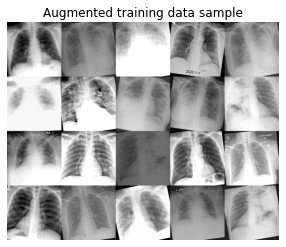

In [120]:
display(X_train)